In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image

In [51]:
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

def load_image(image_path, transform):
    return transform(Image.open(image_path)).unsqueeze(0)

style_img = load_image("./style.jpg", transform)
content_img = load_image("./content.jpg", transform)

style_img.shape, content_img.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

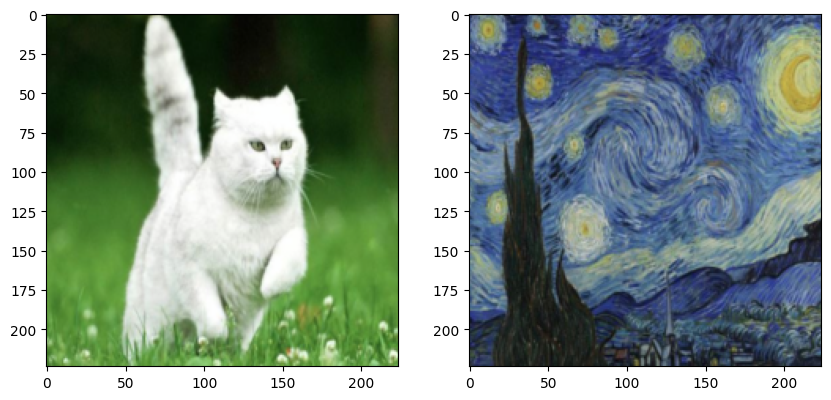

In [52]:
denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))

_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(denorm(content_img).clamp(0, 1)[0].permute(1, 2, 0));
axs[1].imshow(denorm(style_img).clamp(0, 1)[0].permute(1, 2, 0));

In [53]:
vgg_model = torchvision.models.vgg19()
vgg_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [54]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_indices):
        super().__init__()

        self.feature_indices = feature_indices

        self.model = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1).eval().features[:self.feature_indices[-1] + 1]
    
    def forward(self, x):
        out = []
        for idx, layer in enumerate(self.model):
            x = layer(x)
            if idx in self.feature_indices:
                out.append(x)
        
        return out

In [55]:
style_feature_extractor = VGGFeatureExtractor([0, 5, 10, 19, 28]).eval()
content_feature_extractor = VGGFeatureExtractor([25]).eval()

sample_features = style_feature_extractor(torch.randn(1, 3, 224, 224))
print(len(sample_features))
for sample_feature in sample_features:
    print(sample_feature.shape)

5
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 512, 14, 14])


In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [57]:
content_img = content_img.to(device)
style_img = style_img.to(device)
generated_img = content_img.clone().requires_grad_().to(device)

style_feature_extractor = style_feature_extractor.to(device)
content_feature_extractor = content_feature_extractor.to(device)

In [58]:
opt = torch.optim.Adam([generated_img], lr=0.1)

In [59]:
def gram(x):
    B, C, H, W = x.size()
    f = x.view(B, C, W * H)
    G = f.bmm(f.transpose(1, 2)) / (C * H * W)
    
    return G

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


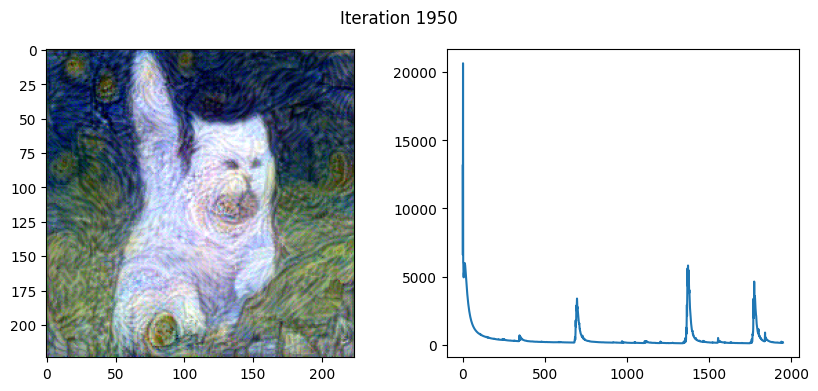

In [60]:
num_iters = 2000
alpha, beta = 1, 1e7
loss_arr = []

loss_mse = torch.nn.MSELoss()

for epoch in range(num_iters):
    content_img_features = content_feature_extractor(content_img)
    style_img_features = style_feature_extractor(style_img)
    generated_content_features = content_feature_extractor(generated_img)
    generated_style_features = style_feature_extractor(generated_img)

    style_loss = 0
    for style_img_feature, gen_style_feature in zip(style_img_features, generated_style_features):
        style_loss += loss_mse(gram(gen_style_feature), gram(style_img_feature))
    
    content_loss = 0
    for content_img_feature, gen_content_feature in zip(content_img_features, generated_content_features):
        content_loss += torch.mean((gen_content_feature - content_img_feature)**2)
    
    loss = alpha*content_loss + beta*style_loss

    opt.zero_grad()
    loss.backward()
    opt.step()

    loss_arr.append(loss.item())

    if epoch % 50 == 0:
        clear_output()
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(f"Iteration {epoch}")
        axs[0].imshow(denorm(generated_img).detach().cpu().squeeze(0).permute(1, 2, 0));
        axs[1].plot(loss_arr)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


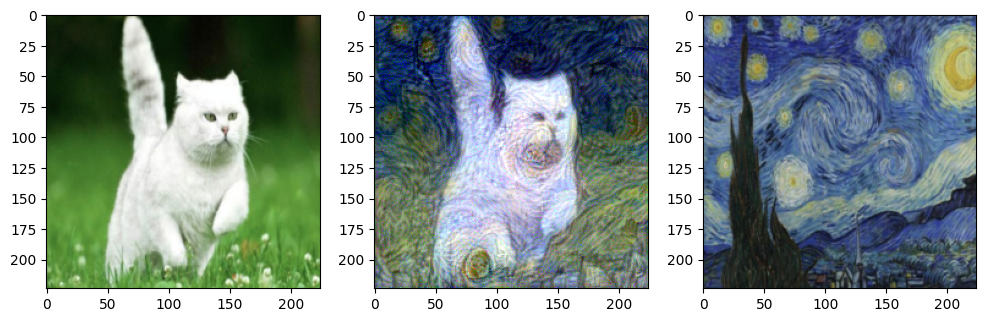

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(denorm(content_img).detach().cpu().squeeze(0).permute(1, 2, 0))
axs[1].imshow(denorm(generated_img).detach().cpu().squeeze(0).permute(1, 2, 0));
axs[2].imshow(denorm(style_img).detach().cpu().squeeze(0).permute(1, 2, 0));
plt.show()